In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import numpy as np
import yfinance as yf

In [3]:
def Drawdown(serie_retorno: pd.Series):
  if isinstance(serie_retorno, pd.Series):
    retornos_acc = (1+serie_retorno).cumprod()-1
    picos_retornos = retornos_acc.cummax()
    drawdown = ((1+retornos_acc)-(1+picos_retornos))/(1+picos_retornos)
    return pd.DataFrame({"Retornos_Acc": retornos_acc, 
                         "Picos_Retornos": picos_retornos, 
                         "Drawdown": drawdown})
  else:
        raise TypeError("Esperado que serie_retorno seja um objeto do tipo Series")  

In [4]:
yf.pdr_override()
tickers = "^BVSP ^GSPC GC=F USDBRL=X"
carteira = yf.download(tickers, interval='1mo', start="2008-01-01")["Close"]
carteira.columns = ["OURO", "DOLAR", "IBOV", "S&P500"]
carteira = carteira.dropna()
carteira["OURO_BRL"]=carteira["OURO"]*carteira["DOLAR"]
carteira["S&P500_BRL"]=carteira["S&P500"]*carteira["DOLAR"]

[*********************100%***********************]  4 of 4 completed


In [5]:
retornos = carteira.pct_change()[1:]

In [6]:
Drawdown(retornos['IBOV']).head()

,Retornos_Acc,Picos_Retornos,Drawdown
Date,,,
2008-02-01,0.067221,0.067221,0.000000
2008-03-01,0.024845,0.067221,-0.039708
2008-04-01,0.140830,0.140830,0.000000
2008-05-01,0.220256,0.220256,0.000000
2008-07-01,0.000252,0.220256,-0.180293


#Medidas de Risco: Semi-Desvio, VaR and CVaR
Vamos analisar algumas medidas de risco de queda. Já vimos como calcular drawdown no notebook 04, agora veremos 3 medidas populares e desenvolveremos código para calculá-las e adicioná-las à nossa caixa de ferramentas.

A primeira medida é a mais simples, que é a semi-desvio, que nada mais é do que a volatilidade do subconjunto de retornos que são negativos.

In [7]:
def semidesvio(r):
    """
    Retorna o semi-desvio aka semi-desvio negativo de r
    r deve ser um objeto do tipo "Series" ou "DataFrame", caso contrário ocorrerá um erro
    """
    if isinstance(r, pd.DataFrame) or isinstance(r, pd.Series):
      is_negative = r < 0
      return r[is_negative].std(ddof=0)
    else:
        raise TypeError("Esperado que r seja um objeto do tipo Series ou DataFrame")

In [8]:
semidesvio(retornos)

OURO          0.034533
DOLAR         0.029810
IBOV          0.050062
S&P500        0.033715
OURO_BRL      0.033272
S&P500_BRL    0.036506
dtype: float64

In [9]:
retornos[retornos<0].std(ddof=0)

OURO          0.034533
DOLAR         0.029810
IBOV          0.050062
S&P500        0.033715
OURO_BRL      0.033272
S&P500_BRL    0.036506
dtype: float64

In [10]:
semidesvio(retornos).sort_values()

DOLAR         0.029810
OURO_BRL      0.033272
S&P500        0.033715
OURO          0.034533
S&P500_BRL    0.036506
IBOV          0.050062
dtype: float64

# VaR and CVaR

Veremos três maneiras diferentes de calcular o valor em risco

1. VaR Histórico
2. VaR Gaussiano Paramétrico
3. VaR Modificado (Cornish-Fisher)

Para calcular o VaR histórico em um determinado nível, digamos 5%, tudo o que temos a fazer é encontrar o número tal que 5% dos retornos fiquem abaixo desse número e 95% dos retornos fiquem acima desse número. Em outras palavras, queremos o retorno de 5 percentil.

Felizmente, numpy tem uma função `np.percentile` que calcula exatamente isso.

In [11]:
def VaR_Historico(r, level=5):
    """
    Retorna Valor de Risco (VaR) histórico no nível (level) especificado
    i.e. retorna o número tal qual a porcentagem nível (level) dos retornos
    caiam abaixo desse número, e os por cento (nível 100) estão acima
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(VaR_Historico, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Esperado que r seja um objeto do tipo Series ou DataFrame")

In [12]:
VaR_Historico(retornos, level=1)

OURO          0.118695
DOLAR         0.108264
IBOV          0.224951
S&P500        0.093552
OURO_BRL      0.114700
S&P500_BRL    0.143230
dtype: float64

Observe que, para fins de relatório, é comum inverter o sinal para relatar um número positivo para representar a _perda_ ou seja, o valor que está em risco.


# VaR Condicional Aka Perda Média Esperada

Agora que temos o VaR, o CVaR é muito fácil. Tudo o que precisamos é encontrar a média dos números que caíram abaixo do VaR!

In [13]:
def CVaR_Historico(r, level=5):
    """
    Retorna Valor de Risco (VaR) condicional
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(CVaR_Historico, level=level)
    elif isinstance(r, pd.Series):
        is_beyond = r <= -VaR_Historico(r, level=level)
        return -r[is_beyond].mean()
    else:
        raise TypeError("Esperado que r seja um objeto do tipo Series ou DataFrame")

In [14]:
CVaR_Historico(retornos, level=1).sort_values()

OURO_BRL      0.125456
S&P500        0.132199
DOLAR         0.134752
OURO          0.150631
S&P500_BRL    0.158896
IBOV          0.248554
dtype: float64

## VaR Gaussiano Paramétrico

A ideia por trás disso é muito simples. Se um conjunto de retornos é normalmente distribuído, sabemos, por exemplo, que 50% dos retornos estão abaixo da média e 50% acima.

Também sabemos que aproximadamente dois terços dos retornos estão dentro de 1 desvio padrão. Isso significa que um terço está além de um desvio padrão da média. Como a distribuição normal é simétrica, aproximadamente um sexto (aproximadamente 16%) fica abaixo de um desvio padrão da média. Portanto, se conhecermos a média e o desvio padrão e se assumirmos que os retornos são normalmente distribuídos, o VaR de 16% seria a média menos um desvio padrão.

Em geral, sempre podemos converter um ponto percentual em um z-score (que é o número de desvios padrão da média que um número é). Portanto, se pudermos converter o nível de VaR (como 1% ou 5%) em um z-score, podemos calcular o nível de retorno onde esse percentual de retornos está abaixo dele.

`scipy.stat.norm` contém uma função `ppf()` que faz exatamente isso. Ele pega um percentil como 0,05 ou 0,01 e fornece o z-score correspondente ao da distribuição normal.



In [15]:
from scipy.stats import norm
norm.ppf(.5)

0.0

In [16]:
norm.ppf(.16)

-0.994457883209753

Portanto, tudo o que precisamos fazer para estimar o VaR usando esse método é encontrar o z-score correspondente ao nível percentil e, em seguida, adicionar esses desvios padrão à média, para obter o VaR.

In [17]:
def VaR_Gaussian(r, level=5):
    """
    Retorna o VaR Gaussiano Paramétrico
    """
    # Calcula o Z-Score considerando que temos uma distribuição normal
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))

In [18]:
VaR_Gaussian(retornos).sort_values()

S&P500        0.069608
S&P500_BRL    0.082332
OURO          0.082491
DOLAR         0.088398
OURO_BRL      0.106431
IBOV          0.121464
dtype: float64

In [19]:
VaR_Historico(retornos).sort_values()

S&P500_BRL    0.067063
S&P500        0.075061
DOLAR         0.075861
OURO          0.077572
OURO_BRL      0.087498
IBOV          0.103795
dtype: float64

# Modificação Cornish-Fisher

A modificação Cornish-Fisher é um ajuste elegante e simples.

O z-score nos diz quantos desvios padrão da média precisamos ir para encontrar o VaR. Se os retornos não forem normais, sabemos que o z-score nos dará um número impreciso. A ideia básica é que, como podemos observar a assimetria e a curtose dos dados, podemos ajustar o z-score para cima ou para baixo para obter um z-score modificado. por exemplo. intuitivamente, todas as outras coisas sendo iguais, se a assimetria for negativa, diminuiremos o z-score mais para baixo e, se a assimetria for positiva, aumentaremos.

O z-score ajustado que chamaremos de $z_{cornishfisher}$ dado por:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$



In [20]:
def assimetria(r):
    # Para definir o desvio padrão da população, parametrizar dof=0
    sigma_r = r.std(ddof=0)
    exp = ((r - r.mean())**3).mean()
    return exp/sigma_r**3

In [21]:
def curtose(r):
    # Para definir o desvio padrão da população, parametrizar dof=0
    sigma_r = r.std(ddof=0)
    exp = ((r - r.mean())**4).mean()
    return exp/sigma_r**4

In [22]:
def VaR_Gaussian(r, level=5, modificado=False):
    # Calcula o Z-Score considerando que temos uma distribuição normal
    z = norm.ppf(level/100)
    if modificado:
        # modifica o Z score baseado na assimentria e na curtose observada
        a = assimetria(r)
        k = curtose(r)
        z = (z +
                (z**2 - 1)*a/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(a**2)/36
            )

    return -(r.mean() + z*r.std(ddof=0))

In [23]:
VaR_Gaussian(retornos, modificado=True).sort_values()

OURO_BRL      0.036454
DOLAR         0.056042
S&P500_BRL    0.067636
S&P500        0.068254
OURO          0.085804
IBOV          0.121052
dtype: float64

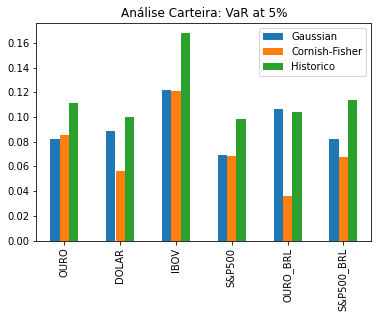

In [24]:
tab_comp = [VaR_Gaussian(retornos), 
            VaR_Gaussian(retornos, modificado=True), 
            CVaR_Historico(retornos)]
comparacao = pd.concat(tab_comp, axis=1)
comparacao.columns=['Gaussian', 'Cornish-Fisher', 'Historico']
comparacao.plot.bar(title="Análise Carteira: VaR at 5%")

Observe que, em alguns casos, o VaR do cornish-fisher é menor, ou seja, estima uma perda menor do que você obteria de uma suposição gaussiana pura. Isso pode acontecer se a assimetria observada for positiva, como é o caso do Ouro convertido em reais.

In [25]:
assimetria(retornos).sort_values(ascending=False)

OURO_BRL      2.179223
DOLAR         1.352035
S&P500_BRL    0.604310
IBOV         -0.068219
S&P500       -0.087157
OURO         -0.240181
dtype: float64